In [ ]:
pip install pytesseract

In [ ]:
pip install opencv-python

In [ ]:
pip install matplotlib

In [1]:
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt
import os
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox

In [26]:
IMG_DIR = 'C:/Users/chosi/Desktop/'

In [27]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

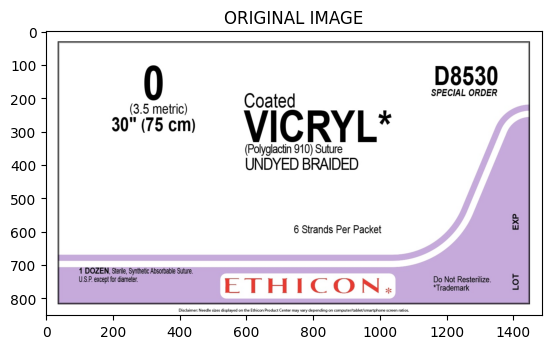

In [28]:
# Plot original image

image = cv2.imread(IMG_DIR + 'D8530.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('ORIGINAL IMAGE')
plt.show()

In [29]:
# Preprocess image 

gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)
images = {'gray': gray, 
          'thresh': thresh, 
          'opening': opening, 
          'canny': canny}

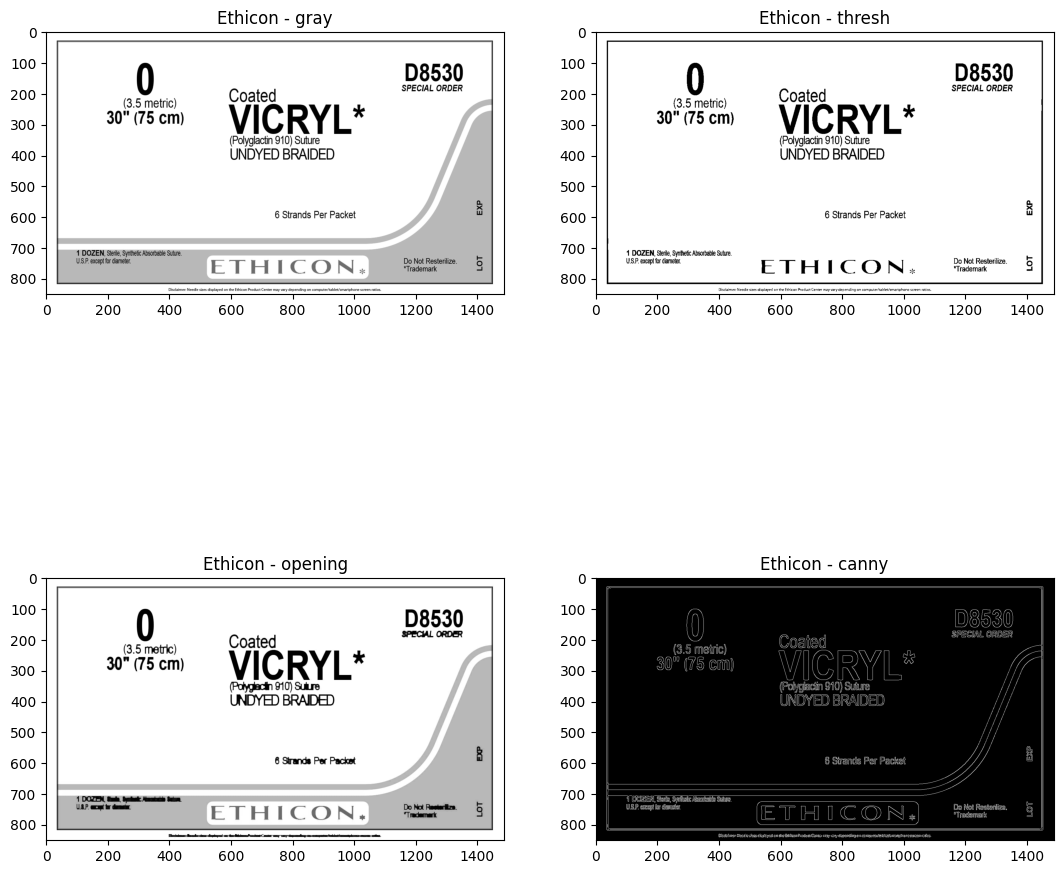

In [30]:
# Plot images after preprocessing

fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('Ethicon - ' + keys[i]) 
    plt.imshow(images[keys[i]], cmap='gray')    

In [31]:
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [32]:
# Get OCR output using Pytesseract

custom_config = r'--oem 3 --psm 6'
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> THRESHOLDED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> OPENED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CANNY EDGE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
0 8530
(3.5 metric) Coated +
sovoem = VICRYL
(Polyglactin 910) Suture
UNDYED BRAIDED
6 Strands Per Packet
ETHICON.


-----------------------------------------
TESSERACT OUTPUT --> THRESHOLDED IMAGE
-----------------------------------------
0 8530
(3.5 metric) Coated +
sovoem = VICRYL
(Polyglactin 910) Suture
UNDYED BRAIDED
6 Strands Per Packet
ETHICON.


-----------------------------------------
TESSERACT OUTPUT --> OPENED IMAGE
-----------------------------------------
0 8530
(3.5 metric) Coated +
sovoem = VICRYL
(Polyglactin 910) Suture
UNDYED BRAIDED
6 Strands Per Packet
ETHICON.


-----------------------------------------
TESSERACT OUTPUT --> CANNY EDGE IMAGE
-----------------------------------------
0 8530
(3.5 metric) Coated +
sovoem = VICRYL
(Polyglactin 910) Suture
UNDYED BRAIDED
6 Strands Per Packet
ETHICON.



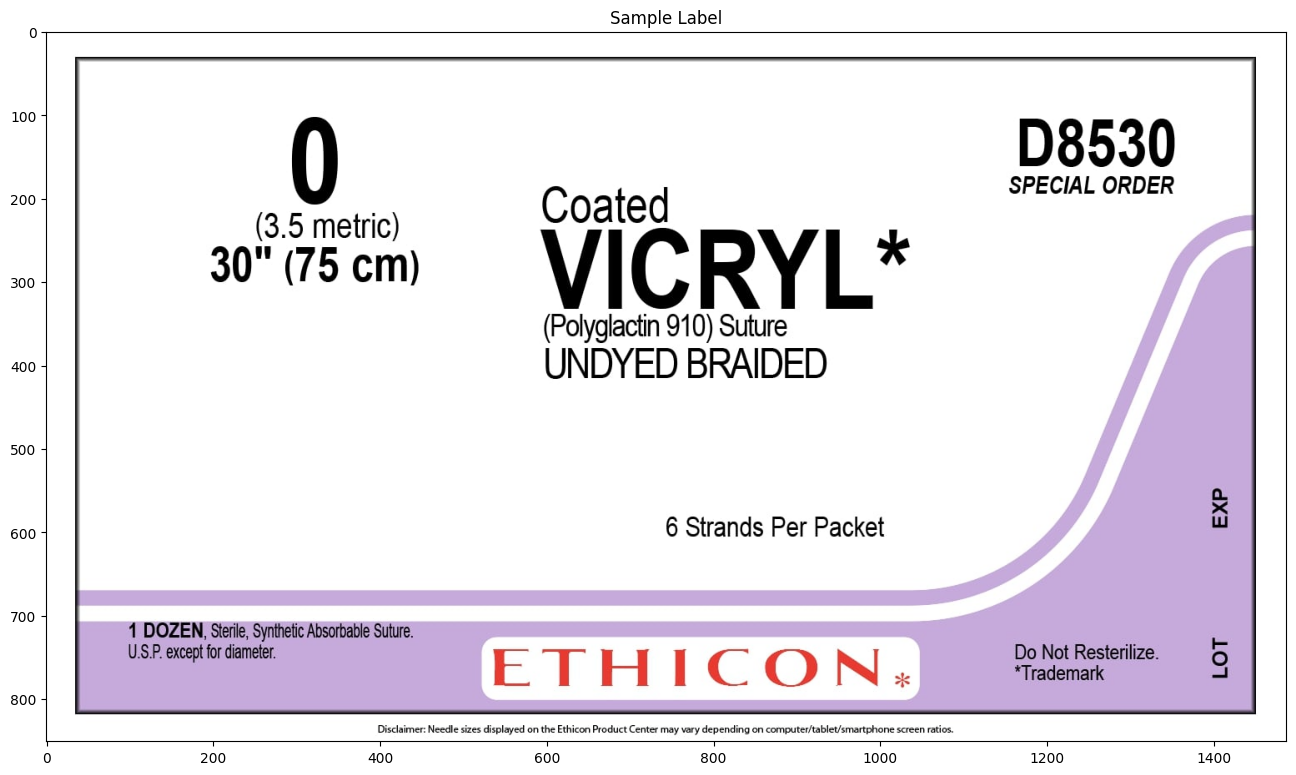

In [33]:
# Plot original image

image = cv2.imread(IMG_DIR + 'D8530.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('Sample Label')
plt.show()

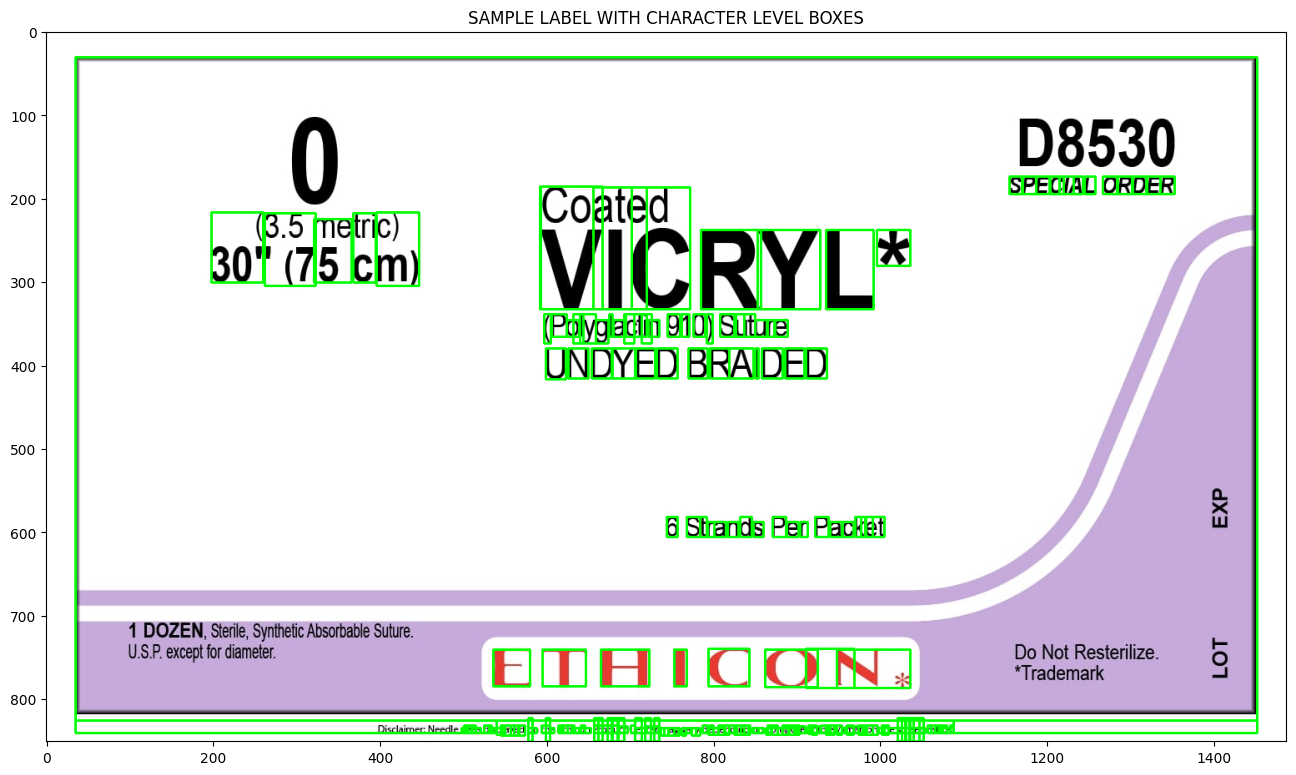

In [34]:
# Plot character boxes on image using pytesseract.image_to_boxes() function

image = cv2.imread(IMG_DIR + 'D8530.jpg')
h, w, c = image.shape
boxes = pytesseract.image_to_boxes(image) 
for b in boxes.splitlines():
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE LABEL WITH CHARACTER LEVEL BOXES')
plt.show()

DATA KEYS: 
 dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


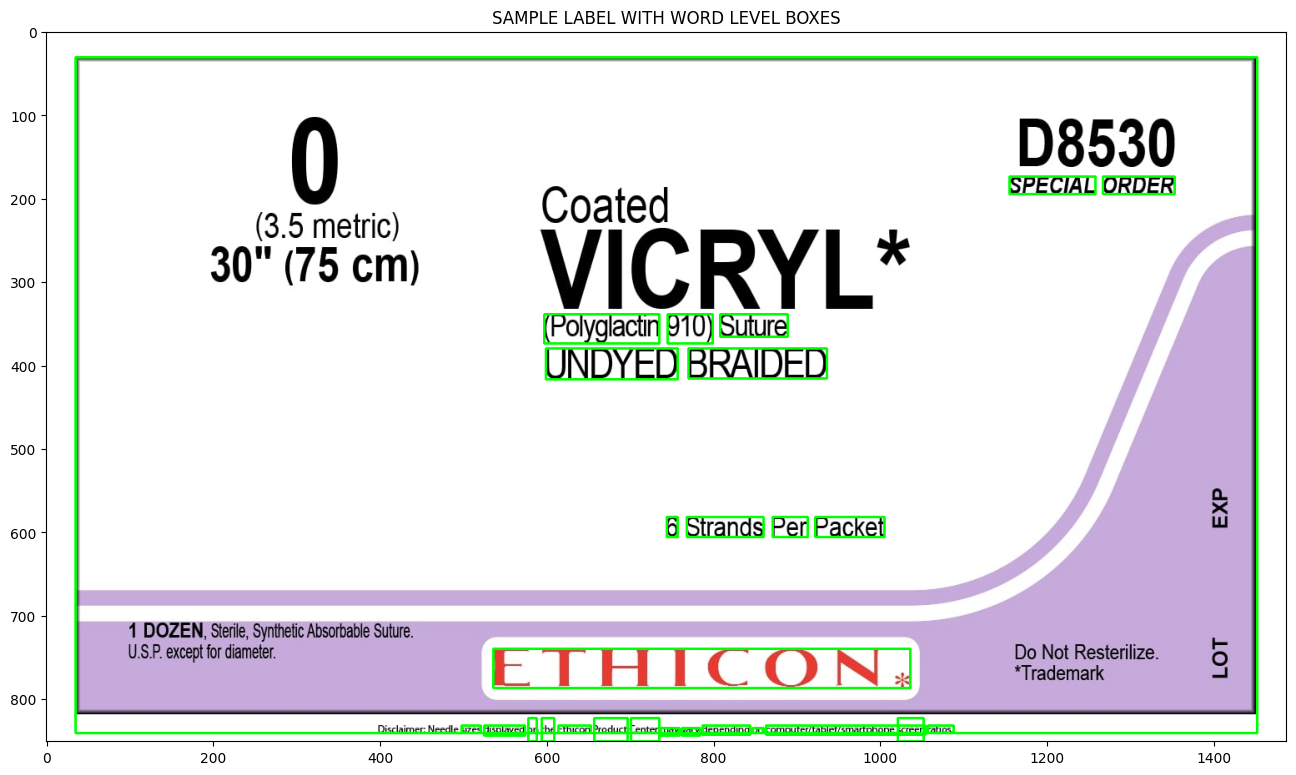

In [35]:
# Plot word boxes on image using pytesseract.image_to_data() function

image = cv2.imread(IMG_DIR + 'D8530.jpg')
d = pytesseract.image_to_data(image, output_type=Output.DICT)
print('DATA KEYS: \n', d.keys())

n_boxes = len(d['text'])
for i in range(n_boxes):
    # condition to only pick boxes with a confidence > 60%
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE LABEL WITH WORD LEVEL BOXES')
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\chosi\AppData\Local\Temp\ipykernel_30460\1240383127.py:5: SyntaxWarning: invalid escape sequence '\d'
  date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'


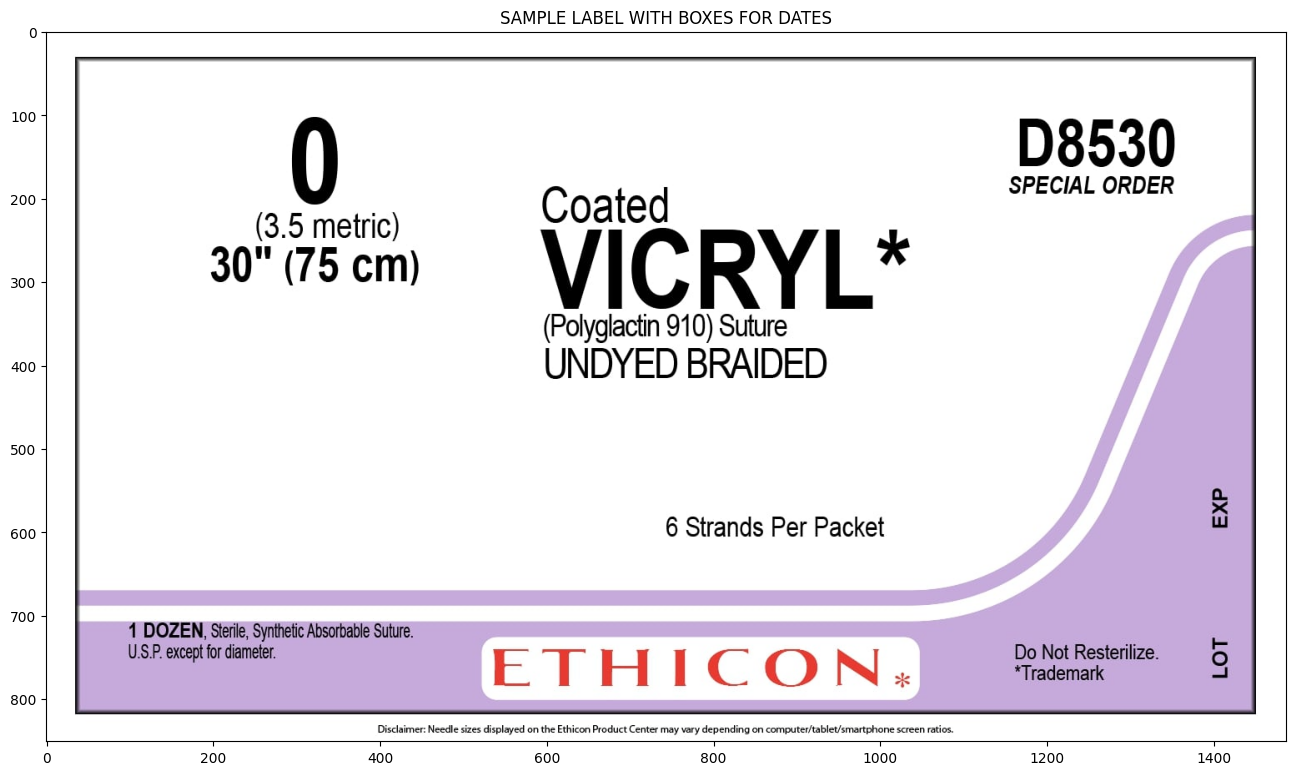

In [36]:
# Plot boxes around text that matches a certain regex template
# In this example we will extract the date from the sample invoice

image = cv2.imread(IMG_DIR + 'D8530.jpg')
date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        if re.match(date_pattern, d['text'][i]):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE LABEL WITH BOXES FOR DATES')
plt.show()

### Detect orientation and script

You can detect the orientation of text in your image and also the script in which it is written. 

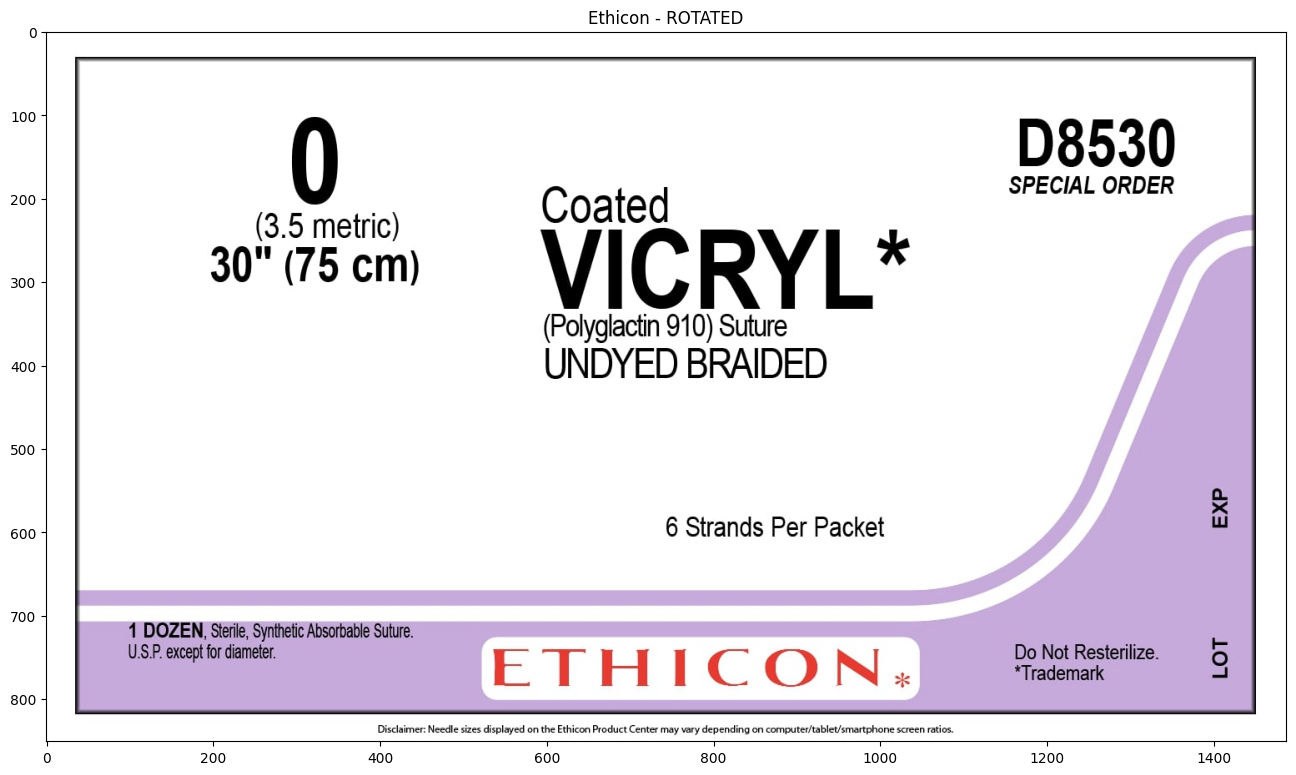

In [37]:
# Plot original image

image = cv2.imread(IMG_DIR + 'D8530.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('Ethicon - ROTATED')
plt.show()

In [38]:
# Get angle and script

osd = pytesseract.image_to_osd(image)
angle = re.search('(?<=Rotate: )\d+', osd).group(0)
script = re.search('(?<=Script: )\w+', osd).group(0)
print("angle: ", angle)
print("script: ", script)

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\w'
C:\Users\chosi\AppData\Local\Temp\ipykernel_30460\3745441755.py:4: SyntaxWarning: invalid escape sequence '\d'
  angle = re.search('(?<=Rotate: )\d+', osd).group(0)
C:\Users\chosi\AppData\Local\Temp\ipykernel_30460\3745441755.py:5: SyntaxWarning: invalid escape sequence '\w'
  script = re.search('(?<=Script: )\w+', osd).group(0)


angle:  0
script:  Latin


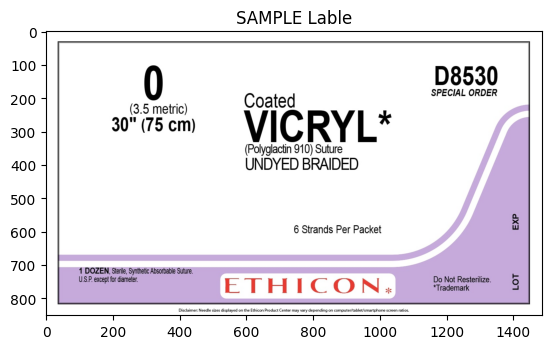

In [39]:
# Plot original image

image = cv2.imread(IMG_DIR + 'D8530.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('SAMPLE Lable')
plt.show()

In [40]:
# Original tesseract output with english language sepcified

custom_config = r'-l eng --oem 3 --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

0 8530
(3.5 metric) Coated +
sovoem = VICRYL
(Polyglactin 910) Suture
UNDYED BRAIDED
6 Strands Per Packet
ETHICON.



In [41]:
# Output with outputbase digits

custom_config = r'--oem 3 --psm 6 outputbase digits'
print(pytesseract.image_to_string(image, config=custom_config))

0 8530
3.5
910
6
.



In [42]:
# Output with a whitelist of characters (here, we have used all the lowercase characters from a to z only)

custom_config = r'-c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

metric oated
sovoem
olyglactinuture
trandseracket



In [43]:
# Output without the blacklisted characters(removed all digits)
custom_config = r'-c tessedit_char_blacklist=0123456789 --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

(. metric) Coated +
sovoem = VICRYL
(Polyglactin $O) Suture
UNDYED BRAIDED
€ Strands Per Packet
ETHICON.



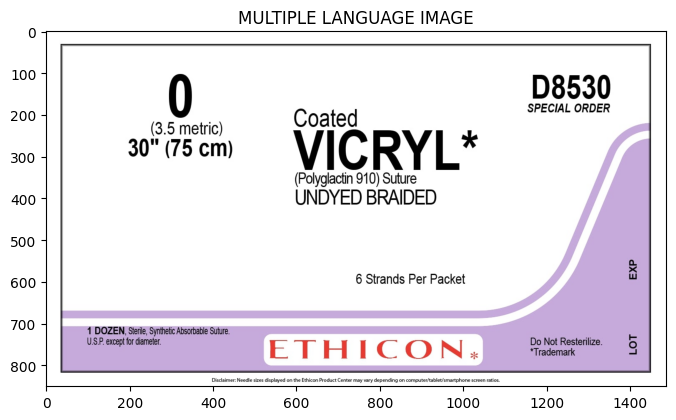

In [44]:
# working with multiple languages

# Plot original image

image = cv2.imread(IMG_DIR + 'D8530.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(8,16))
plt.imshow(rgb_img, cmap = 'gray')
plt.title('MULTIPLE LANGUAGE IMAGE')
plt.show()

In [45]:
# Output with only english language specified

custom_config = r'-l eng --oem 3 --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

0 8530
(3.5 metric) Coated +
sovoem = VICRYL
(Polyglactin 910) Suture
UNDYED BRAIDED
6 Strands Per Packet
ETHICON.



In [46]:
# Output with all languages specified

custom_config = r'-l grc+tha+eng --oem 3 --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

0 8530
(3.5 metric) Coated +
๓ = VICRYL
(Polyglactin 910) Suture
UNDYED BRAIDED
6 Strands Per Packet
ETHICON.



In [22]:
# Function to perform OCR on an image and return the text
def perform_ocr(image, config):
    return pytesseract.image_to_string(image, config=config)

In [23]:
# Function to batch process images and write OCR results to a file
def batch_process_images(image_folder, output_file_path, custom_config):
    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        for image_file in image_files:
            image_path = os.path.join(image_folder, image_file)
            image = cv2.imread(image_path)

            ocr_result = perform_ocr(image, config=custom_config)

            output_file.write(f'Image: {image_file}\n')
            output_file.write(ocr_result + '\n')
            output_file.write('-' * 40 + '\n')

    messagebox.showinfo("Batch Process Complete", f'OCR results have been written to: {output_file_path}')


In [24]:
# Function to handle the "Browse" button click event
def browse_button():
    folder_selected = filedialog.askdirectory()
    folder_path.set(folder_selected)

# Function to handle the "Process Images" button click event
def process_images_button():
    folder_path_str = folder_path.get()
    output_file_path = os.path.join(folder_path_str, 'ocr_results.txt')

    try:
        batch_process_images(folder_path_str, output_file_path, custom_config)
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {str(e)}")


In [25]:
# Create the main GUI window
root = tk.Tk()
root.title("Batch Image Processing")

# Variables
folder_path = tk.StringVar()

# Widgets
label = tk.Label(root, text="Select Image Folder:")
label.pack(pady=10)

entry = tk.Entry(root, textvariable=folder_path, width=40)
entry.pack(pady=10)

browse_button = tk.Button(root, text="Browse", command=browse_button)
browse_button.pack(pady=10)

process_button = tk.Button(root, text="Process Images", command=process_images_button)
process_button.pack(pady=20)

# Run the GUI
root.mainloop()